In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.weightstats import ztest

import math

In [2]:
data = np.load("model_weights/assignments_30.npy")
timseries = np.load("data/timeseries.npy")

clusters = pd.DataFrame(data,index=timseries,columns=['Assigments'])
prop_count = clusters.groupby(pd.Grouper(freq='M'))['Assigments'].value_counts().to_frame().unstack().fillna(0)

/tmp/ipykernel_2162799/1616527630.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prop_count = clusters.groupby(pd.Grouper(freq='M'))['Assigments'].value_counts().to_frame().unstack().fillna(0)


In [ ]:
total =count_stats['sum'].values
total = pd.Series(total)

hist_groups = [[7,3], [1,2,5], [4,12], [8,10,13], [0,6], [9,14], [11]]
hist_groups = pd.Series(hist_groups).to_frame('Hist Clusters')

for idx, row in hist_groups.iterrows():

    clusters = row['Hist Clusters']
    hist_groups.loc[idx,'Sum'] = total.loc[clusters].sum()

hist_groups['Percent'] = (hist_groups['Sum']/total.sum())*100
hist_groups.set_index('Hist Clusters')
display(hist_groups)


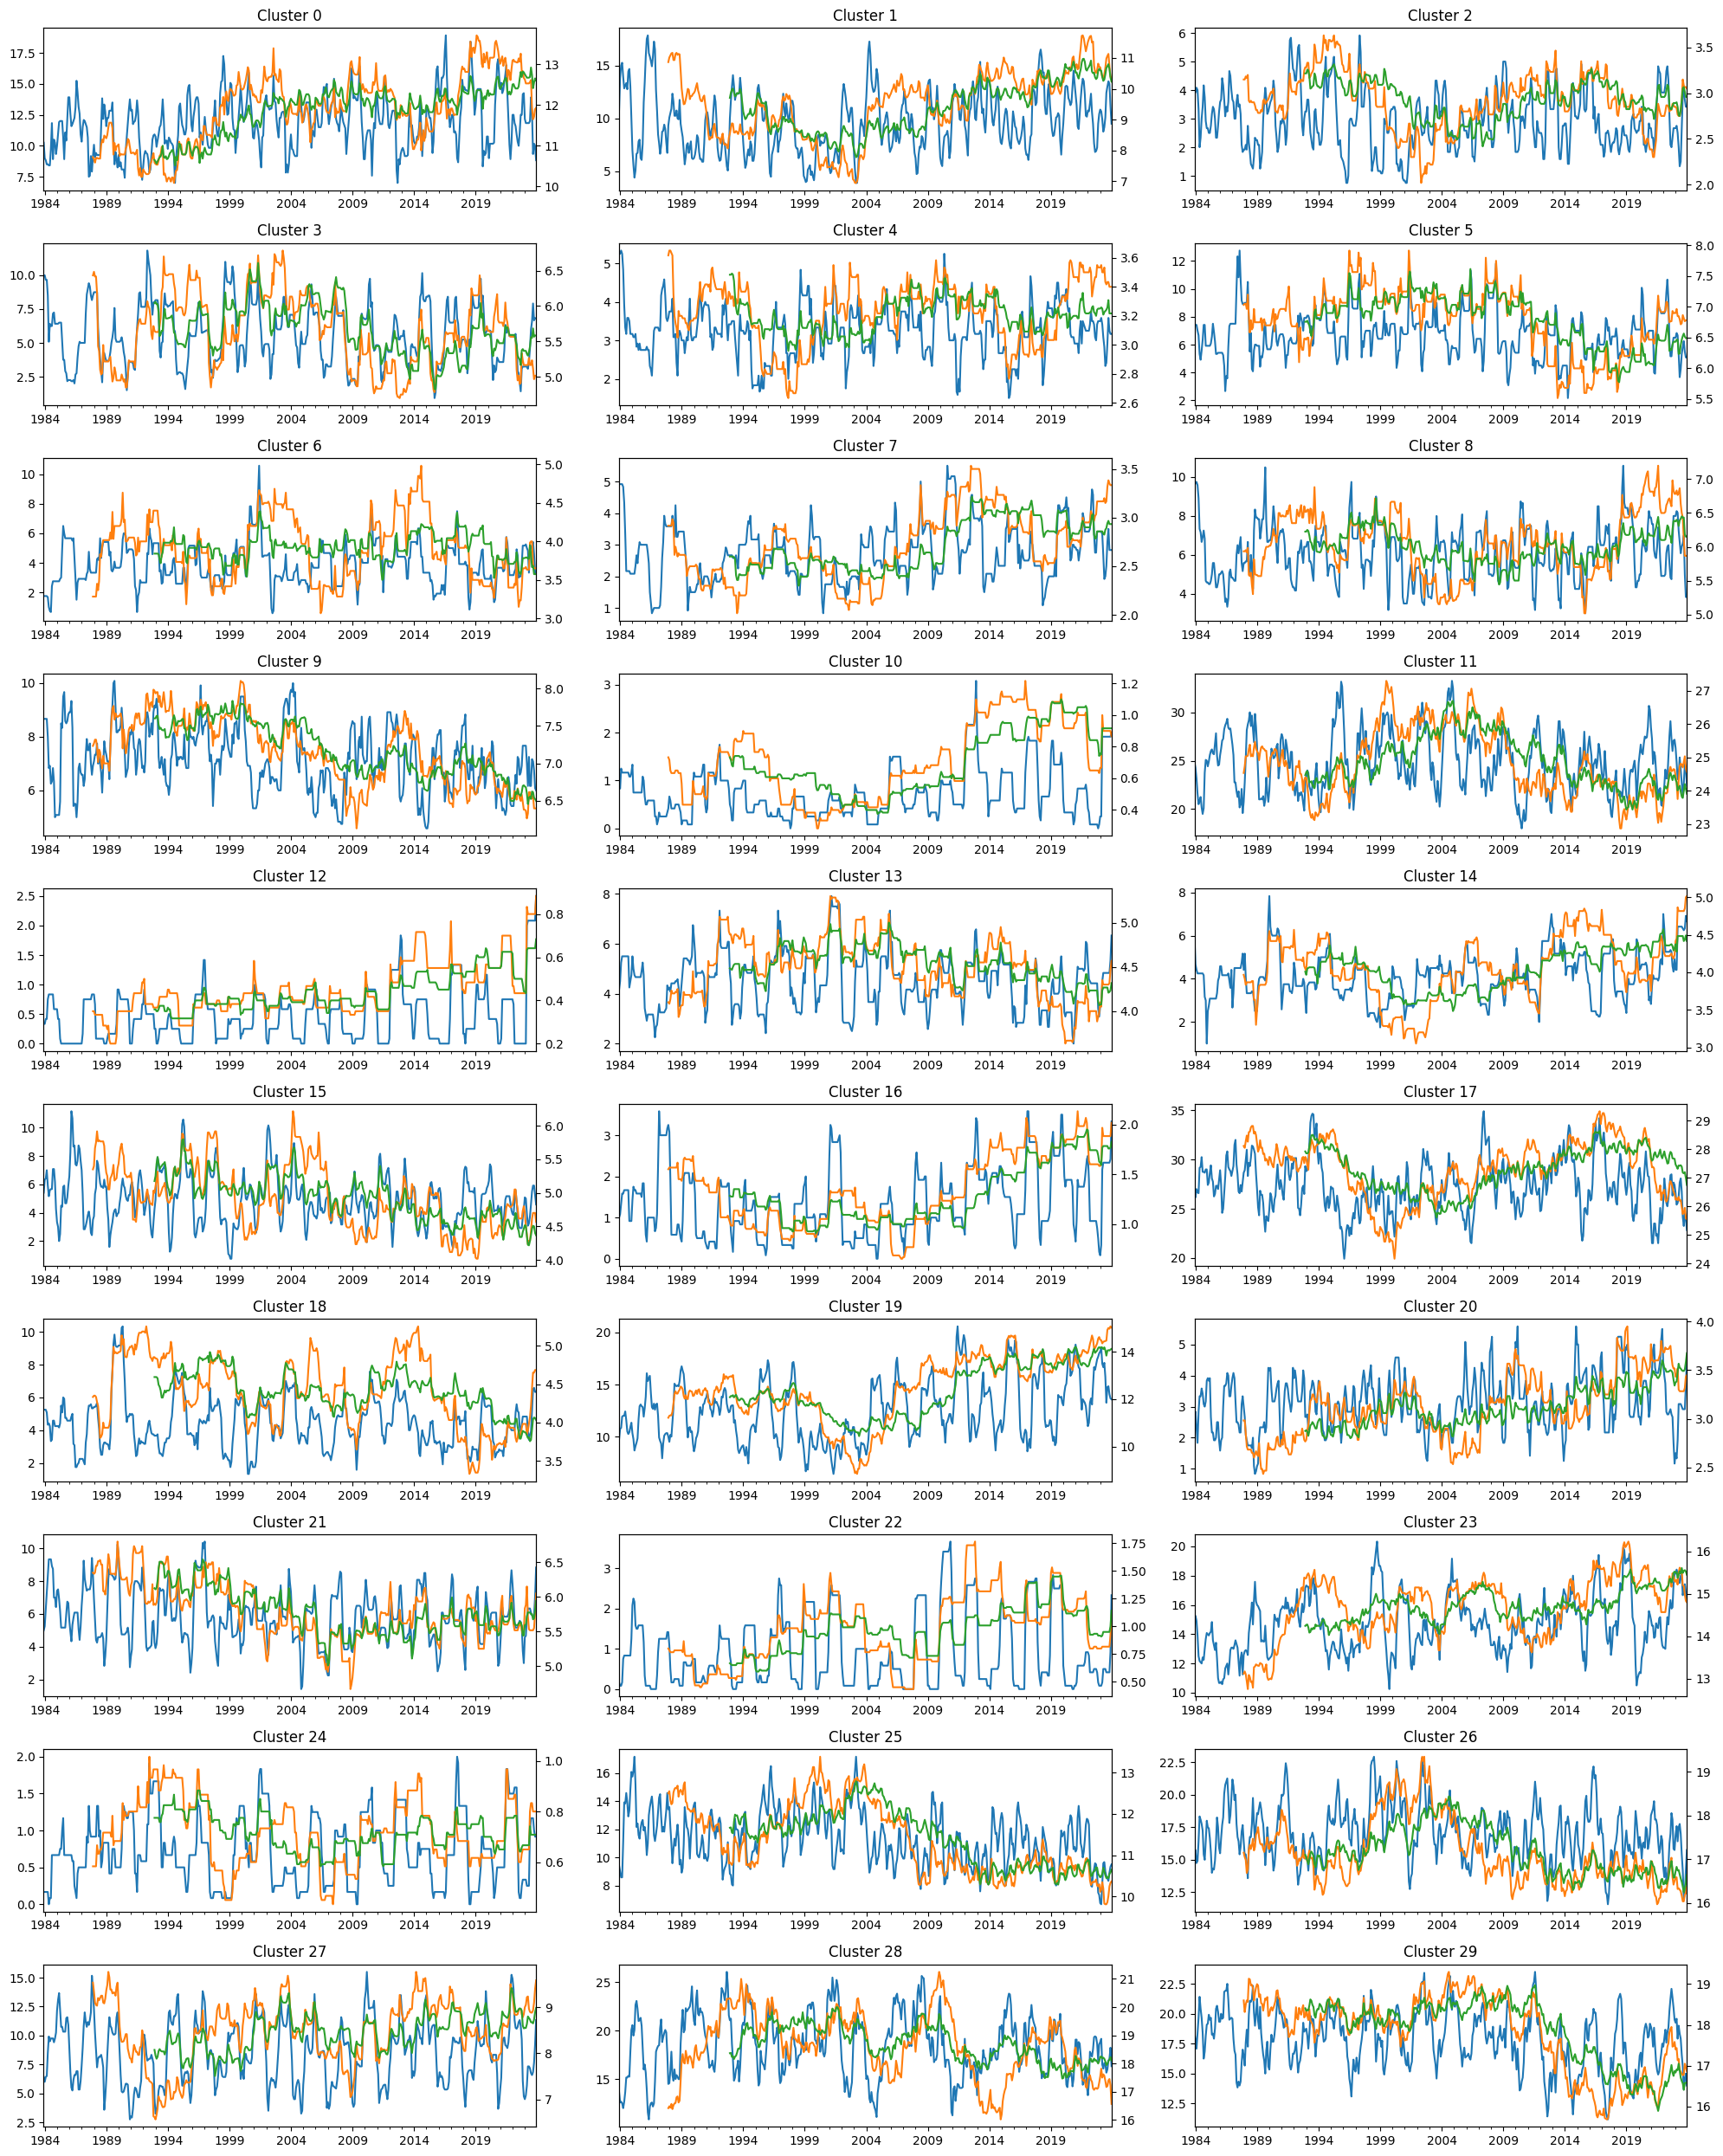

In [53]:
blocks = 3
fig, axs = plt.subplots(math.ceil(len(prop_count.columns) / blocks), blocks, figsize=(20, 25))  # Two columns of subplots

for idx, col in enumerate(prop_count.columns):
    row = idx // blocks
    col_idx = idx % blocks
    
    prop_count.rolling(12).mean()[col].dropna().plot(ax=axs[row, col_idx])
    prop_count.rolling(12*5).mean()[col].dropna().plot(ax=axs[row, col_idx],secondary_y=True)
    prop_count.rolling(12*10).mean()[col].dropna().plot(ax=axs[row, col_idx],secondary_y=True)
    
    axs[row, col_idx].set_title(f'Cluster {idx}')
    
plt.tight_layout()
plt.show()